The resolution of this notebook was done by:
- Ion Bueno Ulacia, 100364530
- Daniel Martín Cruz, 100384121

![uc3m](http://materplat.org/wp-content/uploads/LogoUC3M.jpg)


#### Mount Google Drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Change to assignment directory
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Lab_Exercises_DASS/Lab_Exercise4')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Required Python libraries

In [ ]:
import numpy as np
import pandas as pd
from scipy import io
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Lab Exercise 4
---

# Implementation of a system for human activity detection using smartphone sensor data

### Data analytics for the smart society

### Master in Big Data Analytics

### Course 2021/2022

1. Objective

2. Database

3. Data preprocessing

> 3.1 Segmentation

4. Models

5. Evaluation

6. Conclusion

## 1 - Objective

The objective is to implement a system for human activity detection using monitorized data by means of smartphone sensors. First, we have to preprocess the signals applying recommended techniques from the paper *Activity Recognition Using Inertial Sensing for Healthcare, Wellbeing and Sports Applications: A Survey*. Then, using machine learning algorithms with hyper-parameter tuning, we make the predictions. 

## 2 - Database

The data is composed by sequences of sensor data corresponding to different persons performing a set of activities in seminaturalistic conditions. Each signal has 6 dimensions, since they are captured with an accelerometr and a gyroscope, and the positon is stored in the three axes (x, y and z). The sampling frequency is 25 Hz and there are 5 types of human activity:

1. Laying.
2. Sitting.
3. Climbing Stairs.
4. Standing.
5. Waking.

The data is stored in `AR_database.mat`. There are 8 sequences of training data with dimension 6 x $N_i$, where $N_i$ is the number of observations, with the corresponding labels between 1 and 5. Mention that $N_i$ could differ between the different sequences, $i$, (individuals). As test data, we have 3 sequences with the same number of dimensions (6) and the corresponding duration ($N_i$) per sequence, as well as the corresponding labels between 1 and 5.

First step is loading the data.

In [ ]:
mat = io.loadmat('AR_database.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data_test', 'data_train', 'label_test', 'label_train'])

Then, we store the training and test data as well as the corresponding labels in different variables.

In [ ]:
data_train = mat['data_train']     # training data
data_test = mat['data_test']       # test data
label_train = mat['label_train']   # training labels
label_test = mat['label_test']     # test labels

## 3 - Data preprocessing

Firstly, we have to concatenate the 8 sequences of training data, having as result the matrix `X_train` with the sum of all the $N_i$ as rows and the 6 spatial dimensions as columns. Respect the test data, we only store each sequence in the desired format, ($N_i$ x 6), in the dictionary `X_test`. The reason to separate them is to calculate the accuracy per sequence or individual, as well as the mean of the three.

The labels are also stored in the vector `y_train` and the dictionary `y_test`.

In [ ]:
######################
# Training sequences
######################

X_train = [] # new training data
y_train = [] # new training labels

# Iterate through the train sequences
for i in range(data_train.shape[0]):
    # Select sequence
    arr = data_train[i, 0].T
    labels = label_train[i,0].T
    # Concatenation
    if len(X_train):
        X_train = np.vstack((X_train, arr))
        y_train = np.vstack((y_train, labels))
    else:
        X_train = arr
        y_train = labels
# Print results
print(f'Dimensions X_train: {X_train.shape}')
print(f'Dimensions y_train: {y_train.shape}', '\n')


######################
# Test sequences
######################

X_test = {} # new test data
y_test = {} # new test labels

# Iterate through the test sequences
for i in range(data_test.shape[0]):
    # Select sequence
    X_test[i] = data_test[i, 0].T
    y_test[i] = label_test[i, 0].T
    # Print results
    print(f'Dimensions X_test{i+1}: {X_test[i].shape}')
    print(f'Dimensions y_test{i+1}: {y_test[i].shape}', '\n')

Dimensions X_train: (235297, 6)
Dimensions y_train: (235297, 1) 

Dimensions X_test1: (26782, 6)
Dimensions y_test1: (26782, 1) 

Dimensions X_test2: (28576, 6)
Dimensions y_test2: (28576, 1) 

Dimensions X_test3: (23252, 6)
Dimensions y_test3: (23252, 1) 



The dimensions of each set are printed. Notice the number of rows differ while the number of columns is constant, as desired.

Nevertheless, using all samples do not make much sense since the information could be redundant. In such a short time, $\frac{1}{25Hz}$ seconds, the activity does not change a lot. For this reason, we are going to use sliding windows calculating some statistics in a few amount of samples and use them as our new variables.

### 3.1 - Sliding Windows

The idea is iterate through the six signals and calculate the statistics using a window of samples. The implementation allows overlapping, trying to model the signals more smoothly. The sliding window size as well as the overlapping percentage (from the windows size) are parameters which can be tuned. The calculated statistics are:

* Mean.
* Standard deviation.
* Module.

We tried to include others as the median, as well as different combinations of them, but the ones which provide the best results are these three. Consequently, we have three statistics per signal, in total **18 variables** represented as columns. The number of rows are going to depend on the selected window size as well as the overlapping percentage.

The corresponding labels of the new samples are calculated as the **mode** of each window.

In [ ]:
from scipy import stats

def segmentation(X, y, window, overlap):
    X_seg = [] # new data
    y_seg = [] # new labels

    beg = 0                                          # beginning sliding window
    end = beg+window                                 # end sliding window
    while True:

        # Data
        X_part = X[beg:end, :]                       # sliding window selection
        mu = np.mean(X_part, axis=0)                 # mean
        std = np.std(X_part, axis=0)                 # standard deviation
        module = np.linalg.norm(X_part, axis=0)      # module
        X_stats = np.concatenate((mu, std, module))  # concatenation of the statistics
        # Data concatenation
        if len(X_seg):
            X_seg = np.vstack((X_seg, X_stats))
        else:
            X_seg = X_stats

        # Labels
        y_part = y[beg:end]                          # sliding window selection
        y_stat = stats.mode(y_part)[0][0][0]         # mode
        y_seg = np.append(y_seg, y_stat)             # append new label

        # STOP criteria
        if end == (X.shape[0]-1):
            break

        # New beginning sliding window
        beg = end - round(window * overlap)
        # New end sliding window
        if end+window < X.shape[0]:
            end = beg + window
        else:
            end = X.shape[0]-1
    # Print results
    print(f'Dimensions X_seg: {X_seg.shape}')
    print(f'Dimensions y_seg: {y_seg.shape}')
    return X_seg, y_seg

After several executions, the best results were provided by selecting `window=100` and `overlap=0.5`, meaning that the 50% of the samples are also used in the next iteration of the sliding window.

In [ ]:
window = 100    # sliding window size
overlap = 0.5   # percentage of overlapping respect size sliding window

######################
# Training sequences
######################

print('Training set')
X_train_seg, y_train_seg = segmentation(X_train, y_train, window=window, overlap=overlap)
print()


######################
# Test sequences
######################

X_test_seg = {}
y_test_seg = {}
for i in X_test.keys():
    print(f'Test set {i+1}')
    X_test_seg[i], y_test_seg[i] = segmentation(X_test[i], y_test[i], window=window, overlap=overlap)
    print()

Training set
Dimensions X_seg: (4704, 18)
Dimensions y_seg: (4704,)

Test set 1
Dimensions X_seg: (534, 18)
Dimensions y_seg: (534,)

Test set 2
Dimensions X_seg: (570, 18)
Dimensions y_seg: (570,)

Test set 3
Dimensions X_seg: (464, 18)
Dimensions y_seg: (464,)



As expected, there are 18 variables in each set and a different number of rows. The amount of samples is reduced as compared to before.

## 4 - Models

Once we have the data processed, we employ different machine learning models to make the predictions. We also perform hyper-parameter turning using bayesian optimization with the *sklearn* module `skopt.BayesSearchCV` which speeds up the search. The implemented models are:

* Support Vector Machine (SVM).
* Decision Tree.
* Random Forest.
* Extra Trees.
* Histogram Gradient Boosting.

The tuned models are going to be stored in the dictionary `models`. We fix the `seed` in order to have reproducible results. 

> Note the results could differ depending on the operating system. These ones are from an execution using Kubuntu 20.04.

In [ ]:
models = {}
seed = 41

The steps are the same in the 5 models. We define a pipeline where all cases are just the model excluding the SVM, in which a scaler is applied before. Then the suggested hyper-parameters are defined in a search space where the bayesian optimization is going to take place. We select 5 folds for the cross validation. The best model is stored in the dictionary `models` and their selected hyper-parameter are printed.

In [ ]:
#########
# SVM
#########

from sklearn.svm import SVC

# pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=seed))
])

# search space
param_grid = {
    'svm__kernel': Categorical(['rbf', 'linear']),         
    'svm__gamma': Real(1e-3, 1e-1),  
    'svm__C': Real(10, 100),    
}
 
# Bayes search
clf = BayesSearchCV(
    pipe,
    search_spaces=param_grid,
    cv=5,
    n_jobs=-1,
    random_state=seed,
)

# fitting model
clf.fit(X_train_seg, y_train_seg)
print('Best hyper-parameters:\n', clf.best_params_)
models['SVM'] = clf.best_estimator_

Best hyper-parameters:
 OrderedDict([('svm__C', 41.25044566853082), ('svm__gamma', 0.0550163728514459), ('svm__kernel', 'rbf')])


In [ ]:
###################
# Decision Tree
###################

from sklearn.tree import DecisionTreeClassifier

# pipeline
pipe = Pipeline(steps=[
    ("dt", DecisionTreeClassifier(random_state=seed))
])

# search space
param_grid = {
    'dt__max_depth': Integer(4, 16),          
    'dt__min_samples_split': Integer(2, 10),  
    'dt__min_samples_leaf': Integer(5, 15),   
}

# Bayes search
clf = BayesSearchCV(
    pipe,
    search_spaces=param_grid,
    cv=5,
    n_jobs=-1,
    random_state=seed,
)

# fitting model
clf.fit(X_train_seg, y_train_seg)
print('Best hyper-parameters:\n', clf.best_params_)
models['DecisionTree'] = clf.best_estimator_

Best hyper-parameters:
 OrderedDict([('dt__max_depth', 5), ('dt__min_samples_leaf', 11), ('dt__min_samples_split', 10)])


In [ ]:
###################
# Random Forest
###################

from sklearn.ensemble import RandomForestClassifier

# pipeline
pipe = Pipeline(steps=[
    ("rf", RandomForestClassifier(random_state=seed))
])

# search space
param_grid = {
    'rf__max_depth': Integer(20,30),           
    'rf__min_samples_split': Integer(2,10),   
    'rf__min_samples_leaf': Integer(1,10),    
}

# Bayes search
clf = BayesSearchCV(
    pipe,
    search_spaces=param_grid,
    cv=5,
    n_jobs=-1,
    random_state=seed,
)

# fitting model
clf.fit(X_train_seg, y_train_seg)
print('Best hyper-parameters:\n', clf.best_params_)
models['RandomForest'] = clf.best_estimator_

Best hyper-parameters:
 OrderedDict([('rf__max_depth', 20), ('rf__min_samples_leaf', 1), ('rf__min_samples_split', 6)])


In [ ]:
#################
# Extra Trees
#################

from sklearn.ensemble import ExtraTreesClassifier

# pipeline
pipe = Pipeline(steps=[
    ("et", ExtraTreesClassifier(random_state=seed))
])


# search space
param_grid = {
    'et__max_depth': Integer(30, 40),           
    'et__min_samples_split': Integer(2,20),   
    'et__min_samples_leaf': Integer(1,10),    
}

# Bayes search
clf = BayesSearchCV(
    pipe,
    search_spaces=param_grid,
    cv=5,
    n_jobs=-1,
    random_state=seed,
)

# fitting model
clf.fit(X_train_seg, y_train_seg)
print('Best hyper-parameters:\n', clf.best_params_)
models['ExtraTrees'] = clf.best_estimator_

Best hyper-parameters:
 OrderedDict([('et__max_depth', 30), ('et__min_samples_leaf', 2), ('et__min_samples_split', 20)])


In [ ]:
################################
# Histogram Gradient Boosting
################################

from sklearn.ensemble import HistGradientBoostingClassifier

# pipeline
pipe = Pipeline(steps=[
    ("hgb", HistGradientBoostingClassifier(random_state=seed))
])


# search space
param_grid = {
    'hgb__learning_rate': Real(0.01, 0.9),           
    'hgb__max_iter': Integer(200, 500),   
    'hgb__max_leaf_nodes': Integer(10, 30)    
}

# Bayes search
clf = BayesSearchCV(
    pipe,
    search_spaces=param_grid,
    cv=5,
    n_jobs=-1,
    random_state=seed,
)

# fitting model
clf.fit(X_train_seg, y_train_seg)
print('Best hyper-parameters:\n', clf.best_params_)
models['HistogramGradientBoosting'] = clf.best_estimator_

Best hyper-parameters:
 OrderedDict([('hgb__learning_rate', 0.3041665083767272), ('hgb__max_iter', 200), ('hgb__max_leaf_nodes', 10)])


## 5 - Evaluation

It is important to notice that the evaluation of the model is not straightforward due to the previous preprocessing and the nature of the data. As we are applying a sliding window in the 6 signals, the total amount of samples is reduced and consequently the labels. Remember the label was the mode of the corresponding window. 

As we are interested in the evaluation of the whole samples, we have to perform a post-processing step. It consists of expanding the selected labels to recover the original size. Mention that the number of replicated labels are going to depend on the window size as well as the overlapping percentage. It is an iterative process where we have to be careful at the end of the vector.

In a real application this step may not be useful, since the usual utility is predicting the activity after certain time, not in samples obtained with such short time. However, in order to have an objective result for this data, it is required to have as predictions as test samples.

This one corresponds with the function `expand_predictions`, being `m` the original number of samples and `y_seg` the predictions with the reduced size.

In [ ]:
def expand_predictions(m, y_seg):
    n = y_seg.shape[0]  # original samples
    steps = int(m/n)    # steps to fill
    preds = []          # expanded predictions
    i = 0
    while True:
        preds = np.append(preds, np.repeat(y_seg[i], steps))                # fill whole space
        i += 1
        # end of sequence
        if i==n:
            preds = np.append(preds, np.repeat(y_seg[i-1], m - n*steps))    # fill end of sequence
            break
    return preds

We calculate the accuracy per test set as well as the mean using all the implemented models. The accuracy is obtained using the function `accuracy_score` from *sklearn*, using as input the expanded labels. The results are stored in the `df_results` data frame.

In [ ]:
# Index data frame
index = ['Test set ' + str(i) for i in np.arange(1, len(X_test)+1, 1)]        
index.append('Mean')
# Data frame
df_results = pd.DataFrame(columns=models.keys(), index=index)                 
df_results.index.name = 'Accuracy'
# Dictionary of predictions by all models
y_pred = {}                                                                   

# Iterate through the models
for col, model in models.items():
    y_pred[col] = []
    acc = []
    # Iterate through the test sequences
    for i, y_true in y_test.items():
        # Original predictions
        y_pred_seg = model.predict(X_test_seg[i])
        # Expanded predicitons
        y_pred[col].append(expand_predictions(y_true.shape[0], y_pred_seg))
        # Accuracy
        acc.append(accuracy_score(y_true, y_pred[col][-1]))
    # Mean accuracy
    acc.append(np.mean(acc))
    df_results[col] = acc
    
df_results

,SVM,DecisionTree,RandomForest,ExtraTrees,HistogramGradientBoosting
Accuracy,,,,,
Test set 1,0.800612,0.667202,0.797439,0.843962,0.786498
Test set 2,0.892287,0.843855,0.895157,0.903905,0.846445
Test set 3,0.911879,0.885300,0.886074,0.881774,0.882118
Mean,0.868259,0.798786,0.859557,0.876547,0.838354


The models have a similar performance, with a mean accuracy between **0.80 and 0.88**. Notice how the first test sequence is the one with the lowest accuracy, indicating us that is the most difficult to predict, independently of the used model.

Now the model with the larger mean accuracy is selected.

In [ ]:
best_model = list(models.keys())[np.argmax(df_results.iloc[-1, :])]                      # name best model
y_best_pred = y_pred[best_model]                                                         # predictions by the best model
acc_best = df_results[best_model].values                                                 # accuracies obtained by the best model
categories = ['Laying', 'Sitting', 'Climbing Stairs', 'Standing', 'Walking']             # categories
print(f'Best model is {best_model} with a mean accuracy of {round(acc_best[-1], 6)}')    

Best model is ExtraTrees with a mean accuracy of 0.876547


In this case the best model corresponds with the **Extra Trees**, with a mean accuracy of **of 0.876547**. We are going to analyze how it predicts the different classes for the three test sequences ploting the confusion matrices. We have assigned the categories to the labels as specified in the assignment:

| Label | Human activity |
|---|---|
| 1 | Laying |
| 2 | Sitting |
| 3 | Climbing Stairs |
| 4 | Standing |
| 5 | Walking |

Accuracy = 0.843962 



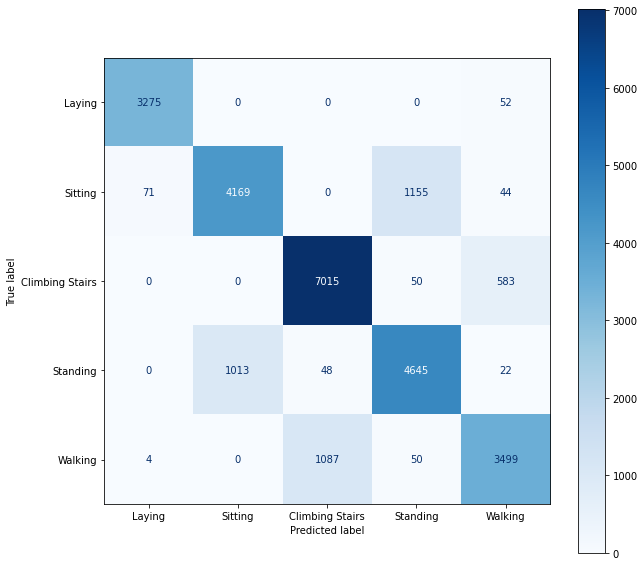

In [ ]:
#####################
# Test sequence 1
#####################

test_set = 1

cm = confusion_matrix(y_test[test_set-1], y_best_pred[test_set-1])   # confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=categories)         # display confusion matrix
fig, ax = plt.subplots(figsize=(10,10))                              # figure
disp.plot(ax=ax, cmap='Blues')
print(f'Accuracy = {round(acc_best[test_set-1], 6)}', '\n')

As mentioned before, in the first test set we have obtained the worst result. Excluding the *Laying* class, there are errors in all the categories. Mention how most of the misclassifications are between two classes instead of distributed between all the categories. These errors make sense because they are between similar activities, for example *Climbing Stairs* and *Walking*, which both imply movement. Also between *Standing* and *Sitting*, where there is not movement.

Accuracy = 0.903905 



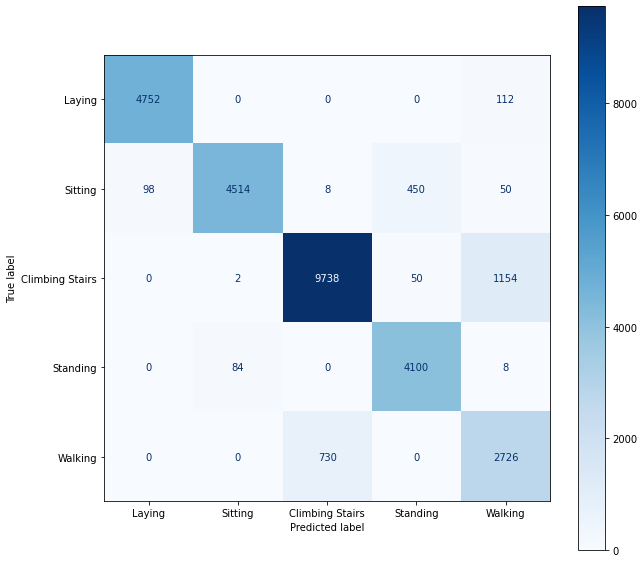

In [ ]:
#####################
# Test sequence 2
#####################

test_set = 2

cm = confusion_matrix(y_test[test_set-1], y_best_pred[test_set-1])   # confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=categories)         # display confusion matrix
fig, ax = plt.subplots(figsize=(10,10))                              # figure
disp.plot(ax=ax, cmap='Blues')
print(f'Accuracy = {round(acc_best[test_set-1], 6)}', '\n')

In the second test sequence we obtained the most accurate prediction. Only in the class *Walking* there is a considerable amount of errors. The same missclassification pattern is followed, but with a lower ratio.

Accuracy = 0.881774 



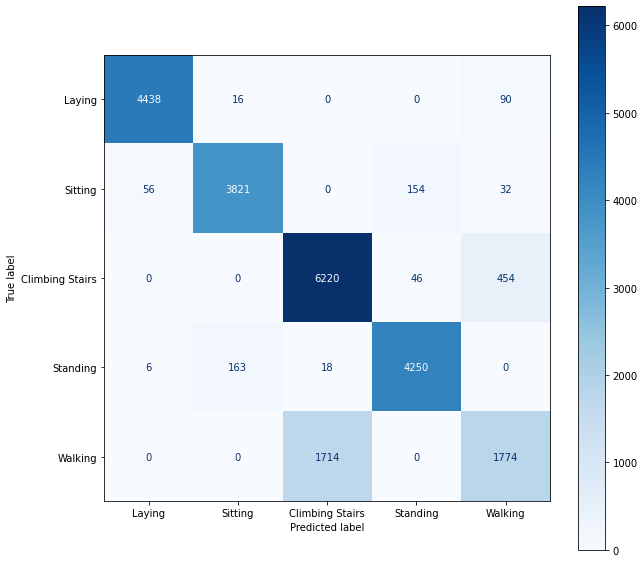

In [ ]:
#####################
# Test sequence 3
#####################

test_set = 3

cm = confusion_matrix(y_test[test_set-1], y_best_pred[test_set-1])   # confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=categories)         # display confusion matrix
fig, ax = plt.subplots(figsize=(10,10))                              # figure
disp.plot(ax=ax, cmap='Blues')
print(f'Accuracy = {round(acc_best[test_set-1], 6)}', '\n')

The performance in the third sequence is a bit worse than the second one. The missclassifications between similar activities are also present.

## 6 - Conclusion

In spite of a few missclassifications, the implemented model predicts well all the human activities using only the information stored by the sensors. In order to improve the model, feature engineering could be applied, reducing the dimensions with Principal Component Analysis  (PCA), Local Discriminant Analysis (LDA) or Independent Component Analysis (ICA). We can also use other statistics as variables, for example, features from the frequency domain as the spectral Energy, or from the time-frequency domain as wavelet coefficients.

An ensemble of models which includes time series processing and a classifier may work very well with this sequential data. For example, a Recurrent Neural Network (RNN) which models how the data evolves with a Support Vector Machine (SVM) to provide a classification.

Mention the performance would be better if the evaluation is performed only on the real predictions obtained with the sliding window, which at the end is more practical, as commented before.